In [139]:
import uproot
import awkward as ak
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use(Path('../style.mplstyle'))
matplotlib.rcParams["text.usetex"] = False

import basf2 as b2

In [140]:
decfile_nophotos = "decfile_nophotos.DEC"
decfile_photos = "decfile_photos.DEC"

In [141]:
# from decfiles/dec/1250010001.dec

In [142]:
%%writefile $decfile_photos
Decay Upsilon(4S)
0.5 B+sig B-         VSS;
0.5 B-sig B+         VSS;
Enddecay

Decay B+sig
1.0 K+ nu_e anti-nu_e           PHOTOS PHSP;
Enddecay
CDecay B-sig

End

Overwriting decfile_photos.DEC


In [143]:
%%writefile $decfile_nophotos
noPhotos

Decay Upsilon(4S)
0.5 B+sig B-         VSS;
0.5 B-sig B+         VSS;
Enddecay

Decay B+sig
1.0 K+ nu_e anti-nu_e           PHSP;
Enddecay
CDecay B-sig

End

Overwriting decfile_nophotos.DEC


In [144]:
def generate(decfile, outfile, num_events=10000):
    print(f"\nGenerate {outfile} from {decfile}\n")
    main = b2.create_path()
    main.add_module("EventInfoSetter", evtNumList=[num_events])
    main.add_module("EvtGenInput", userDECFile=decfile)
    main.add_module("RootOutput", outputFileName=outfile, branchNames="MCParticles", basketSize=1024*1024)
    main.add_module("Progress")
    b2.process(main)

In [145]:
b2.set_log_level(b2.LogLevel.WARNING) # suppress info messages other than Progress
num_events = 100000
generate(decfile_nophotos, "nophotos.root", num_events=num_events)
generate(decfile_photos, "photos.root", num_events=num_events)


Generate nophotos.root from decfile_nophotos.DEC

[INFO] Begin of new run.
[INFO] Processed:   1 runs,      1/100000 events.
[INFO] Processed:   1 runs,      2/100000 events.
[INFO] Processed:   1 runs,      3/100000 events.
[INFO] Processed:   1 runs,      4/100000 events.
[INFO] Processed:   1 runs,      5/100000 events.
[INFO] Processed:   1 runs,      6/100000 events.
[INFO] Processed:   1 runs,      7/100000 events.
[INFO] Processed:   1 runs,      8/100000 events.
[INFO] Processed:   1 runs,      9/100000 events.
[INFO] Processed:   1 runs,     10/100000 events.
[INFO] Processed:   1 runs,     20/100000 events.
[INFO] Processed:   1 runs,     30/100000 events.
[INFO] Processed:   1 runs,     40/100000 events.
[INFO] Processed:   1 runs,     50/100000 events.
[INFO] Processed:   1 runs,     60/100000 events.
[INFO] Processed:   1 runs,     70/100000 events.
[INFO] Processed:   1 runs,     80/100000 events.
[INFO] Processed:   1 runs,     90/100000 events.
[INFO] Processed:   1 ru

In [146]:
def get_particles(filename):
    p4_columns = ["energy", "momentum_x", "momentum_y", "momentum_z"]
    columns = ["mother", "pdg", "status"] + p4_columns
    with uproot.open(f"{filename}:tree") as tree:
        particles = tree.arrays(
            columns,
            aliases={key: f"MCParticles.m_{key}" for key in columns},
            how="zip"
        )["jagged0"]
    p4 = ak.concatenate(
        [particles[field][..., np.newaxis] for field in p4_columns],
        axis=2
    )
    p4 = ak.to_regular(p4, axis=-1)
    particles["p4"] = p4
    return particles

In [147]:
def is_neutrino(pdg):
    # probably checking for abs(pdg) == 12 would be sufficient
    # since DEC file specifies only electron neutrinos for Knunu decay
    return (abs(pdg) == 12) | (abs(pdg) == 14) | (abs(pdg) == 16)

In [148]:
def get_nunu_candidates(particles):
    pdg = particles.pdg
    mother = particles.mother
    particles = ak.with_field(
        particles,
        pdg[mother - 1], # mother index is 1-based
        "mother_pdg",
    )
    neutrinos = particles[is_neutrino(particles.pdg)]
    c1, c2 = ak.unzip(ak.combinations(neutrinos, 2))
    # filter on same mother and B as mother for both neutrinos
    mask = ((c1.mother_pdg == c2.mother_pdg) & (abs(c1.mother_pdg) == 521))
    return c1[mask], c2[mask]

In [149]:
def mass_squared(p4):
    return p4[..., 0] ** 2 - ak.sum(p4[..., 1:] ** 2, axis=-1)

In [150]:
particles_photos = get_particles("photos.root")
particles_nophotos = get_particles("nophotos.root")

In [151]:
def q2(nu1, nu2):
    return mass_squared(nu1.p4 + nu2.p4)

In [152]:
q2_nophotos = q2(*get_nunu_candidates(particles_nophotos))
q2_photos = q2(*get_nunu_candidates(particles_photos))

In [153]:
fig, axs = plt.subplots(nrows=2, sharex=True, height_ratios=[4,1])

bins = np.linspace(0,23,23)
kwargs = dict(bins=bins, histtype="step", linewidth=2)
h1, *_ = axs[0].hist(ak.flatten(q2_nophotos), label='w/o PHOTOS', **kwargs)
h2, *_ = axs[0].hist(ak.flatten(q2_photos), label='w/ PHOTOS', **kwargs, linestyle="--")

axs[0].set_ylabel('Entries')

axs[0].legend()

axs[1].plot((bins[:-1]+bins[1:])/2, (h1-h2) / h2, 'o')

plt.savefig('../results/figs/photos_corrections.pdf')

The following works because of the same random seed. However, may not always work, due to how random numbers change when additional stuff requests further random numbers (e.g. photos) (?, to clarify)

Text(0.5, 0, 'difference q^2 (nophotos - photos)')

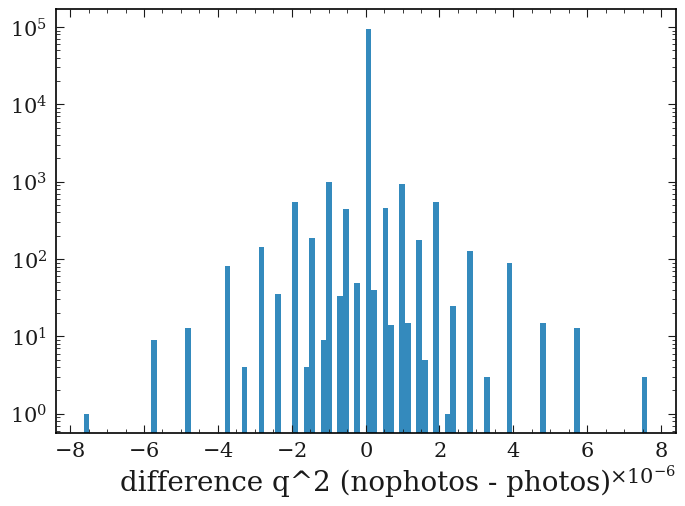

In [154]:
plt.hist(q2_nophotos[:, 0] - q2_photos[:, 0], bins=100)
plt.yscale("log")
plt.xlabel("difference q^2 (nophotos - photos)")